## Evaluate [bge-m3](https://huggingface.co/BAAI/bge-m3) model on the dataset

In [1]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
# from tqdm.auto import tqdm
import numpy as np
from scipy import spatial
from IPython.display import clear_output

/export/home/co21btech11001/.conda/envs/nlp_env/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load dataset

In [2]:
df_ques_url = pd.read_pickle('data/questions_relevant_urls.pkl')
df_ques_url = pd.DataFrame(df_ques_url)
print(df_ques_url.shape)
df_ques_url.head(3)

(36925, 2)


,question,relevant_docs_urls
0,What is (are) keratoderma with woolly hair ?,[https://ghr.nlm.nih.gov/condition/keratoderma...
1,How many people are affected by keratoderma wi...,[https://ghr.nlm.nih.gov/condition/keratoderma...
2,What are the genetic changes related to kerato...,[https://ghr.nlm.nih.gov/condition/keratoderma...


In [3]:
df_kb = pd.read_pickle('data/docs_url_content_bge_pre_trained.pkl')
df_kb = pd.DataFrame(df_kb)
print(df_kb.shape)
df_kb.head(2)

(7873, 3)


,document_url,document_content,doc_embedding
0,https://ghr.nlm.nih.gov/condition/keratoderma-...,Keratoderma with woolly hair: MedlinePlus Gene...,"[-0.038389873, -0.005646622, -0.039817445, -0...."
1,https://ghr.nlm.nih.gov/condition/kniest-dyspl...,Kniest dysplasia: MedlinePlus Genetics\nSkip n...,"[-0.015272127, 0.015771694, -0.027792098, 0.00..."


## Load model

In [4]:
model_name = "BAAI/bge-m3"
model = SentenceTransformer(model_name, trust_remote_code=True)
model = model.to('cuda')

## Evaluate

In [5]:
def cos_sim(a, b):
    return 1 - spatial.distance.cosine(a, b)

def retrieve(ques, df_kb, model):
    question_embedding = model.encode(ques, convert_to_tensor=True).cpu().numpy()
    # Copy the 'document_url' and 'doc_embedding' columns to a new dataframe
    df_kb_copy = df_kb[['document_url', 'doc_embedding']].copy()
    # Calculate the cosine similarity between the question embedding and all document embeddings
    df_kb_copy['cosine_similarity'] = df_kb_copy['doc_embedding'].apply(
        lambda x: cos_sim(question_embedding, x))
    # Sort the dataframe by the cosine similarity in descending order
    df_kb_copy = df_kb_copy.sort_values(by='cosine_similarity', ascending=False)
    ret_urls = df_kb_copy['document_url'].values
    return ret_urls

def recall_at_k(top_retrieved_urls, relevant_urls):
    common = set(top_retrieved_urls).intersection(set(relevant_urls))
    return len(common) / len(relevant_urls)

def mrr_at_k(top_retrieved_urls, relevant_urls):
    res = []
    for i, url in enumerate(top_retrieved_urls):
        if url in relevant_urls:
            res.append(1/(i+1))
    if len(res) == 0:
        return 0
    return np.mean(res)

In [6]:
recall_1_li = []; mrr_1_li = []
recall_3_li = []; mrr_3_li = []
recall_10_li = []; mrr_10_li = []
recall_100_li = []; mrr_100_li = []

In [7]:
f = open('logs/eval_pre_trained.txt', 'w')

In [8]:
import time

start_time = time.time()

complete = 0
total = len(df_ques_url)
for _, row in df_ques_url.iterrows():
    ques = row['question']
    relevant_urls = row['relevant_docs_urls']
    try:
        retrieved_urls = retrieve(ques, df_kb, model)
    except Exception as e:
        f.write(f"row: {_}, ques: {ques}, error: {e}\n")
        f.flush()
        continue
    temp_recall_1 = recall_at_k(retrieved_urls[:1], relevant_urls)
    temp_mrr_1 = mrr_at_k(retrieved_urls[:1], relevant_urls)
    temp_recall_3 = recall_at_k(retrieved_urls[:3], relevant_urls)
    temp_mrr_3 = mrr_at_k(retrieved_urls[:3], relevant_urls)
    temp_recall_10 = recall_at_k(retrieved_urls[:10], relevant_urls)
    temp_mrr_10 = mrr_at_k(retrieved_urls[:10], relevant_urls)
    temp_recall_100 = recall_at_k(retrieved_urls[:100], relevant_urls)
    temp_mrr_100 = mrr_at_k(retrieved_urls[:100], relevant_urls)

    recall_1_li.append(temp_recall_1); mrr_1_li.append(temp_mrr_1)
    recall_3_li.append(temp_recall_3); mrr_3_li.append(temp_mrr_3)
    recall_10_li.append(temp_recall_10); mrr_10_li.append(temp_mrr_10)
    recall_100_li.append(temp_recall_100); mrr_100_li.append(temp_mrr_100)

    complete += 1
    percent_comp = (complete/total)*100
    clear_output(wait=True)
    print(f"Completed: {complete}/{total}: ({percent_comp:.2f}%)")

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken:.2f} seconds")

Completed: 36925/36925: (100.00%)
Time taken: 3084.88 seconds


In [9]:
f.close()

In [10]:
print(len(recall_1_li), len(mrr_1_li))

36925 36925


In [ ]:
recall_1_score = np.mean(recall_1_li); mrr_1_score = np.mean(mrr_1_li)
recall_3_score = np.mean(recall_3_li); mrr_3_score = np.mean(mrr_3_li)
recall_10_score = np.mean(recall_10_li); mrr_10_score = np.mean(mrr_10_li)
recall_100_score = np.mean(recall_100_li); mrr_100_score = np.mean(mrr_100_li)

print(f"Recall@1: {recall_1_score:.4f}")
print(f'Recall@3: {recall_3_score:.4f}')
print(f'Recall@10: {recall_10_score:.4f}')
print(f'Recall@100: {recall_100_score:.4f}')
print()
print(f'MRR@1: {mrr_1_score:.4f}')
print(f'MRR@3: {mrr_3_score:.4f}')
print(f'MRR@10: {mrr_10_score:.4f}')
print(f'MRR@100: {mrr_100_score:.4f}')

Recall@1: 0.8958
Recall@3: 0.9799
Recall@10: 0.9900
Recall@100: 0.9956

MRR@1: 0.9002
MRR@3: 0.9364
MRR@10: 0.9378
MRR@100: 0.9379


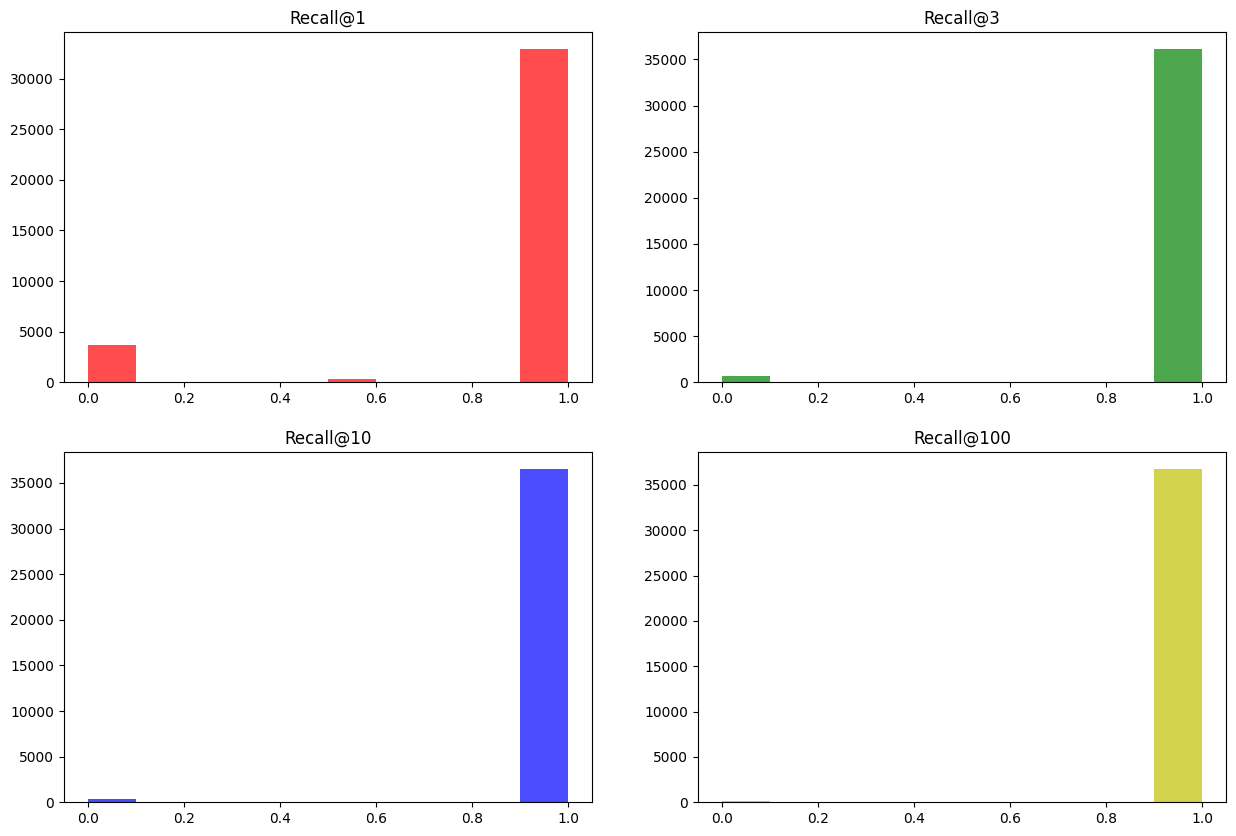

In [12]:
# Plot recall scores on histograms
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].hist(recall_1_li, bins=10, color='r', alpha=0.7)
ax[0, 0].set_title('Recall@1')
ax[0, 1].hist(recall_3_li, bins=10, color='g', alpha=0.7)
ax[0, 1].set_title('Recall@3')
ax[1, 0].hist(recall_10_li, bins=10, color='b', alpha=0.7)
ax[1, 0].set_title('Recall@10')
ax[1, 1].hist(recall_100_li, bins=10, color='y', alpha=0.7)
ax[1, 1].set_title('Recall@100')
plt.show()

In [13]:
# Find the indices for which recall@1 is less than 0.6
recall_1_li = np.array(recall_1_li)
indices = np.where(recall_1_li < 0.6)[0]
print(indices, indices.shape)

[   45    46    49 ... 36760 36920 36924] (4001,)


In [14]:
# Print a question and the relevant urls for which recall@1 is less than 0.6
idx = indices[0]
ques = df_ques_url.iloc[idx]['question']
relevant_urls = df_ques_url.iloc[idx]['relevant_docs_urls']
print(f"Question: {ques}")
print(f"Relevant URLs:")
for url in relevant_urls:
    print(url)

Question: What is (are) trisomy 18 ?
Relevant URLs:
https://ghr.nlm.nih.gov/condition/trisomy-18


In [15]:
retrieved_urls = retrieve(ques, df_kb, model)
print(f"Retrieved URLs:")
for url in retrieved_urls[:5]:
    print(url)

Retrieved URLs:
https://www.nlm.nih.gov/medlineplus/ency/article/001661.htm
https://ghr.nlm.nih.gov/condition/trisomy-18
https://ghr.nlm.nih.gov/condition/tetrasomy-18p
https://ghr.nlm.nih.gov/condition/trisomy-13
https://ghr.nlm.nih.gov/condition/triple-x-syndrome
